In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

import sqlite3
import sqlalchemy

import os
from zipfile import ZipFile
from urllib.request import urlretrieve
from itertools import chain

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, acovf
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from time_series.analysis import *

plt.style.use('seaborn')

C:\Users\mgavin\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Reading the Zillow Data

### Create Python Package for Allowing Flexibility and Quick Access to Data

In [2]:
zillow_site = requests.get('https://www.zillow.com/research/data/')

In [3]:
zillow_site

<Response [200]>

In [4]:
zillow_site.text[:100]

'\n<!doctype html>\n<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#">\n<head>\n<meta chars'

In [5]:
z_df = pd.read_csv("http://files.zillowstatic.com/research/public/Zip/Zip_MedianRentalPrice_AllHomes.csv")

In [6]:
z_df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07
0,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,...,3400.0,3500.0,3500.0,3405.0,3402.5,3400.0,3395.0,3400.0,3400.0,3402.5
1,60657,Chicago,IL,Chicago,Cook,2,NaN,NaN,NaN,NaN,...,1833.0,1800.0,1750.0,1795.0,1750.0,1895.0,1800.0,1877.5,1975.0,2025.0
2,10023,New York,NY,New York,New York,3,NaN,NaN,3415.0,3275.0,...,3575.0,3697.0,3700.0,3700.0,3500.0,3500.0,3600.0,3562.5,3562.5,3662.5
3,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,NaN,NaN,NaN,NaN,...,1850.0,1850.0,1850.0,1850.0,1850.0,1850.0,1950.0,1895.0,1895.0,1900.0
4,77494,Katy,TX,Houston,Harris,5,NaN,NaN,NaN,NaN,...,2260.0,2200.0,2200.0,2125.0,2100.0,2100.0,2125.0,2150.0,2100.0,2100.0


In [7]:
len(z_df)

3260

## Data Exploration - Looking at North Park Rent

In [8]:
North_Park = z_df[z_df['RegionName'] == 92104]

In [9]:
North_Park_melted = pd.melt(North_Park,value_name='RentalPrice',var_name='Date',id_vars=['RegionName','City','State','Metro','CountyName','SizeRank'])

In [10]:
North_Park_melted.head()

,RegionName,City,State,Metro,CountyName,SizeRank,Date,RentalPrice
0,92104,San Diego,CA,San Diego,San Diego,371,2010-02,NaN
1,92104,San Diego,CA,San Diego,San Diego,371,2010-03,NaN
2,92104,San Diego,CA,San Diego,San Diego,371,2010-04,NaN
3,92104,San Diego,CA,San Diego,San Diego,371,2010-05,NaN
4,92104,San Diego,CA,San Diego,San Diego,371,2010-06,NaN


In [11]:
North_Park_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
RegionName     102 non-null int64
City           102 non-null object
State          102 non-null object
Metro          102 non-null object
CountyName     102 non-null object
SizeRank       102 non-null int64
Date           102 non-null object
RentalPrice    79 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 6.5+ KB


In [12]:
North_Park_melted['Date'] = pd.to_datetime(North_Park_melted['Date'],format='%Y-%m')
North_Park_melted = North_Park_melted.dropna().set_index('Date')
North_Park_melted.head()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice
Date,,,,,,,
2012-01-01,92104,San Diego,CA,San Diego,San Diego,371,1225.0
2012-02-01,92104,San Diego,CA,San Diego,San Diego,371,1345.0
2012-03-01,92104,San Diego,CA,San Diego,San Diego,371,1200.0
2012-04-01,92104,San Diego,CA,San Diego,San Diego,371,1200.0
2012-05-01,92104,San Diego,CA,San Diego,San Diego,371,1100.0


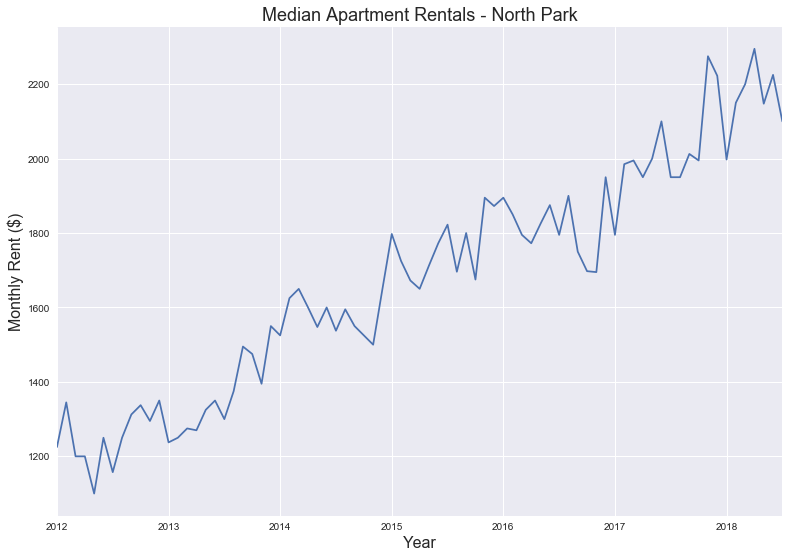

In [13]:
North_Park_melted['RentalPrice'].plot(figsize=(13,9))
plt.title('Median Apartment Rentals - North Park',fontsize=18)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Monthly Rent ($)',fontsize=16)
plt.show()

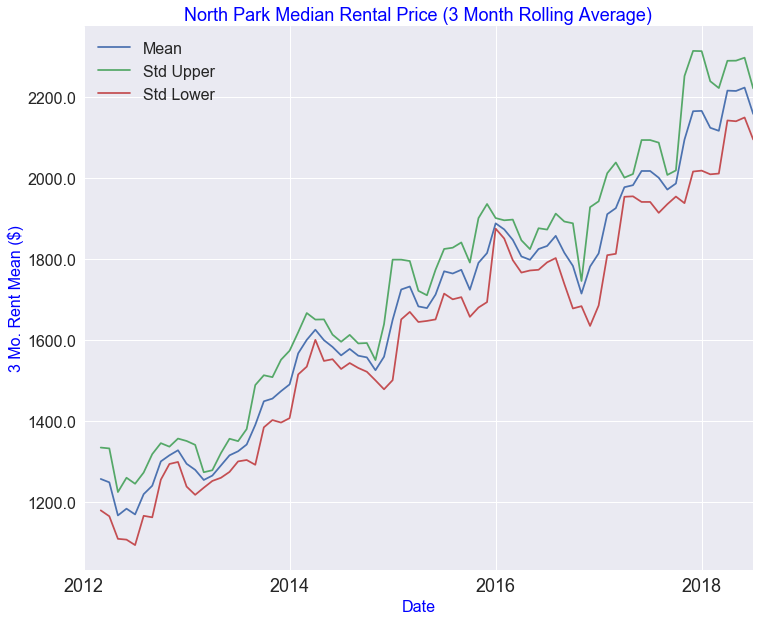

In [14]:
ax = North_Park_melted.rolling(3).mean()['RentalPrice'].plot(figsize=(12,10))

North_Park_melted.rolling(3).std().add(North_Park_melted.rolling(3).mean())['RentalPrice'].plot(ax=ax)

North_Park_melted['RentalPrice'].rolling(3).mean().sub(North_Park_melted['RentalPrice'].rolling(3).std()).plot(ax=ax)

ax.set_xticks(['2012','2014','2016','2018'])
ax.set_xticklabels(['2012','2014','2016','2018'],fontdict={'fontsize':18})
#ax.set_yticks('1200','1400','1600','1800','2000','2200'])
ax.set_yticklabels(ax.get_yticks(),fontdict={'fontsize':16})
ax.set_xlabel('Date',fontsize=16,color='blue')
ax.set_ylabel('3 Mo. Rent Mean ($)',fontsize=16,color='blue')

plt.title('North Park Median Rental Price (3 Month Rolling Average)',fontsize=18,color='blue')
plt.legend(['Mean','Std Upper','Std Lower'],fontsize=16)

plt.show()

- Need to put together a package that allows for selecting the Region Type (e.g. Zip Code, Neighborhood)
- Concatenate dataframes with different rooms, square footage as well. 
- Consider comparing Value vs. Rent, though unclear if it will translate meaningfully. 
- Need to import matplotlib.ticker and format to allow string on the y-axis ($ format)

In [15]:
North_Park_melted['StdLower'] = North_Park_melted['RentalPrice'].rolling(3).mean().sub(North_Park_melted['RentalPrice'].rolling(3).std())
North_Park_melted['StdUpper'] = North_Park_melted['RentalPrice'].rolling(3).mean().add(North_Park_melted['RentalPrice'].rolling(3).std())

In [16]:
North_Park_melted.tail()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice,StdLower,StdUpper
Date,,,,,,,,,
2018-03-01,92104,San Diego,CA,San Diego,San Diego,371,2200.0,2010.348342,2221.318324
2018-04-01,92104,San Diego,CA,San Diego,San Diego,371,2295.0,2141.345401,2288.654599
2018-05-01,92104,San Diego,CA,San Diego,San Diego,371,2147.5,2139.403151,2288.930183
2018-06-01,92104,San Diego,CA,San Diego,San Diego,371,2225.0,2148.718227,2296.281773
2018-07-01,92104,San Diego,CA,San Diego,San Diego,371,2100.0,2094.402853,2220.597147


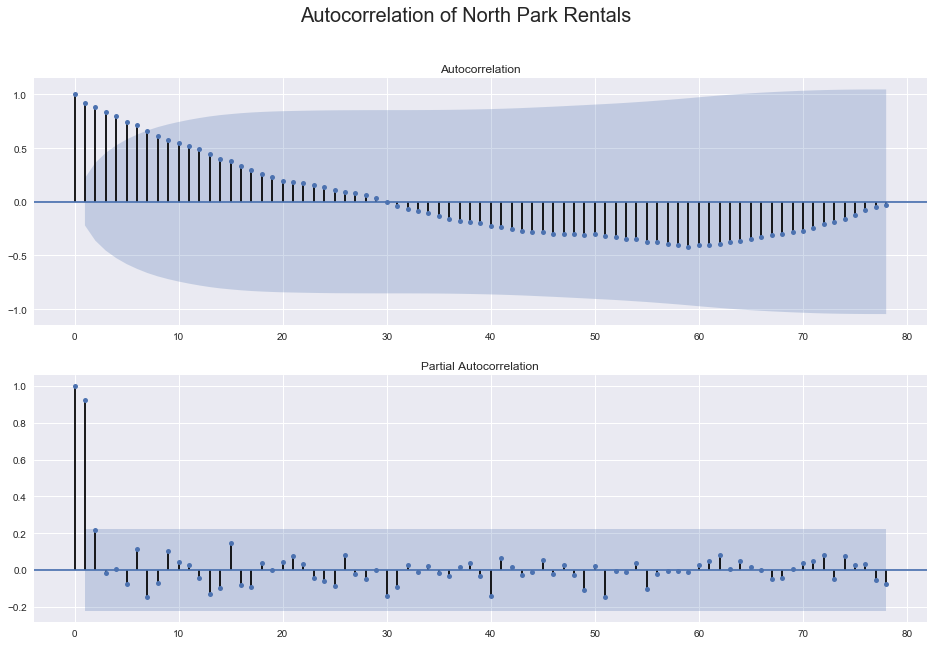

In [17]:
fig, axes = plt.subplots(2,1,figsize=(16,10))

fig.suptitle('Autocorrelation of North Park Rentals',fontsize=20)

tsaplots.plot_acf(North_Park_melted['RentalPrice'],ax=axes[0])

tsaplots.plot_pacf(North_Park_melted['RentalPrice'],ax=axes[1])

plt.show()

### Autocorrelation ###

#### Measures the relation between time point t and previous time points (e.g. t-3) ####

- Based on the ACF graph, there appears to be a correlation between lags 1 through 6
- The PACF graph shows a drop-off, but lag 3 is still significant, which could indicate quarterly trends
- Next is to determine whether there is any seasonality underlying the general upward trend, or if it is mostly noise

In [18]:
def seasonality_monthly(df_input,sampling='M',window='quarterly'):
    

    window_dict = {'quarterly':3,
                   'semiannual':6,
                   'yearly':12}

    quarterly_trends = []
    
    w = window_dict.get(window,3)

    for i in range(w):
    
        df = pd.DataFrame()
        
        quarterly_trends.append(df.append(df_input.iloc[i::w]))
        
    return quarterly_trends

In [19]:
quarterly_list = seasonality_monthly(North_Park_melted)

In [20]:
quarterly_list

[            RegionName       City State      Metro CountyName  SizeRank  \
 Date                                                                      
 2012-01-01       92104  San Diego    CA  San Diego  San Diego       371   
 2012-04-01       92104  San Diego    CA  San Diego  San Diego       371   
 2012-07-01       92104  San Diego    CA  San Diego  San Diego       371   
 2012-10-01       92104  San Diego    CA  San Diego  San Diego       371   
 2013-01-01       92104  San Diego    CA  San Diego  San Diego       371   
 2013-04-01       92104  San Diego    CA  San Diego  San Diego       371   
 2013-07-01       92104  San Diego    CA  San Diego  San Diego       371   
 2013-10-01       92104  San Diego    CA  San Diego  San Diego       371   
 2014-01-01       92104  San Diego    CA  San Diego  San Diego       371   
 2014-04-01       92104  San Diego    CA  San Diego  San Diego       371   
 2014-07-01       92104  San Diego    CA  San Diego  San Diego       371   
 2014-10-01 

In [21]:
annual_groupings = North_Park_melted.select_dtypes(include=['number']).groupby(North_Park_melted.index.year).mean()

In [22]:
annual_groupings.index = pd.to_datetime(annual_groupings.index,format='%Y')

In [23]:
annual_groupings = annual_groupings.resample('MS',convention='start').ffill()
annual_groupings.head()

,RegionName,SizeRank,RentalPrice,StdLower,StdUpper
Date,,,,,
2012-01-01,92104,371,1251.875,1182.816724,1302.349942
2012-02-01,92104,371,1251.875,1182.816724,1302.349942
2012-03-01,92104,371,1251.875,1182.816724,1302.349942
2012-04-01,92104,371,1251.875,1182.816724,1302.349942
2012-05-01,92104,371,1251.875,1182.816724,1302.349942


In [24]:
seasonal_df = pd.concat(quarterly_list,ignore_index=False)

In [25]:
seasonal_df = seasonal_df.sort_index()

In [26]:
seasonal_df = seasonal_df.join(annual_groupings.loc[:,['RentalPrice','StdLower','StdUpper']],lsuffix='_m',rsuffix='_y')

In [27]:
seasonal_df.head()

,RegionName,City,State,Metro,CountyName,SizeRank,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y
Date,,,,,,,,,,,,
2012-01-01,92104,San Diego,CA,San Diego,San Diego,371,1225.0,NaN,NaN,1251.875,1182.816724,1302.349942
2012-02-01,92104,San Diego,CA,San Diego,San Diego,371,1345.0,NaN,NaN,1251.875,1182.816724,1302.349942
2012-03-01,92104,San Diego,CA,San Diego,San Diego,371,1200.0,1179.153227,1334.180106,1251.875,1182.816724,1302.349942
2012-04-01,92104,San Diego,CA,San Diego,San Diego,371,1200.0,1164.617544,1332.049122,1251.875,1182.816724,1302.349942
2012-05-01,92104,San Diego,CA,San Diego,San Diego,371,1100.0,1108.931640,1224.401694,1251.875,1182.816724,1302.349942


In [28]:
seasonal_df = seasonal_df.iloc[:,6:]

In [29]:
seasonal_df['RentalPrice_my'] = seasonal_df['RentalPrice_m'] / seasonal_df['RentalPrice_y']
seasonal_df['StdLower_my'] = seasonal_df['StdLower_m'] / seasonal_df['StdLower_y']
seasonal_df['StdUpper_my'] = seasonal_df['StdUpper_m'] / seasonal_df['StdUpper_y']

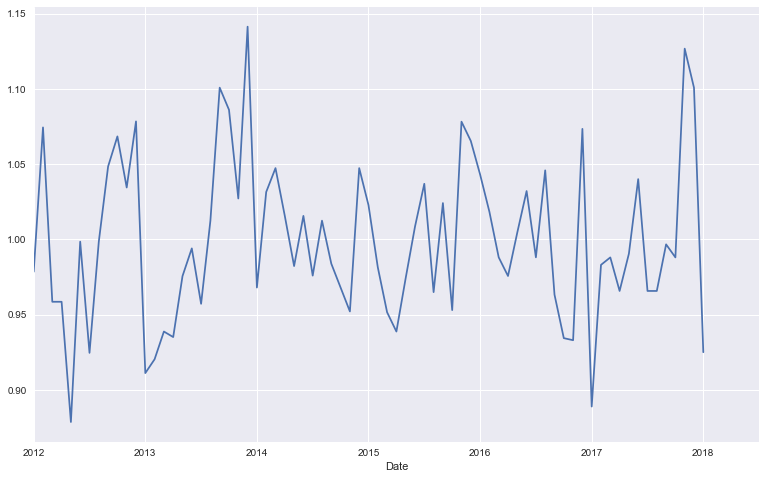

In [30]:
seasonal_df.iloc[:,-3].plot(figsize=(13,8))
plt.show()

In [31]:
quarter_list = []

for index, row in seasonal_df.iterrows():
    
    if index.month in [1,4,7,10]:
        quarter_list.append(1)
        
    elif index.month in [2,5,8,11]:
        quarter_list.append(2)

    else:
        quarter_list.append(3)

        
seasonal_df['QuarterlyGroup'] = quarter_list


In [32]:
seasonal_df.head()

,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y,RentalPrice_my,StdLower_my,StdUpper_my,QuarterlyGroup
Date,,,,,,,,,,
2012-01-01,1225.0,NaN,NaN,1251.875,1182.816724,1302.349942,0.978532,NaN,NaN,1
2012-02-01,1345.0,NaN,NaN,1251.875,1182.816724,1302.349942,1.074388,NaN,NaN,2
2012-03-01,1200.0,1179.153227,1334.180106,1251.875,1182.816724,1302.349942,0.958562,0.996903,1.024441,3
2012-04-01,1200.0,1164.617544,1332.049122,1251.875,1182.816724,1302.349942,0.958562,0.984614,1.022804,1
2012-05-01,1100.0,1108.931640,1224.401694,1251.875,1182.816724,1302.349942,0.878682,0.937535,0.940148,2


In [33]:
seasonal_grouped = seasonal_df.groupby(seasonal_df.index.month).mean()

In [34]:
seasonal_grouped.index = pd.to_datetime(seasonal_grouped.index,format='%m').to_period()

seasonal_grouped.head()

,RentalPrice_m,StdLower_m,StdUpper_m,RentalPrice_y,StdLower_y,StdUpper_y,RentalPrice_my,StdLower_my,StdUpper_my,QuarterlyGroup
Date,,,,,,,,,,
1900-01,1638.928571,1620.342222,1812.713334,1705.445578,1629.502904,1761.120112,0.962514,0.950369,0.985235,1
1900-02,1704.285714,1674.985411,1816.959034,1629.805556,1554.413146,1676.869261,1.001523,0.985807,0.988610,2
1900-03,1683.928571,1605.174297,1746.254274,1629.805556,1554.413146,1676.869261,0.978732,0.989129,0.993369,3
1900-04,1676.785714,1645.821217,1730.845449,1629.805556,1554.413146,1676.869261,0.964917,1.003399,0.977706,1
1900-05,1665.357143,1632.542839,1718.171446,1629.805556,1554.413146,1676.869261,0.967669,0.991705,0.966780,2


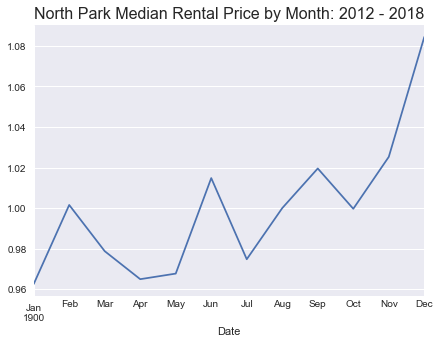

In [35]:
seasonal_grouped['RentalPrice_my'].plot(figsize=(7,5))
plt.title('North Park Median Rental Price by Month: 2012 - 2018',fontsize=16)
plt.show()

- Conclusion from a basic average by month is that rent peaks in December and again in June, for summer rentals

In [36]:
decomposed_df = seasonal_decompose(seasonal_df.iloc[:,0])

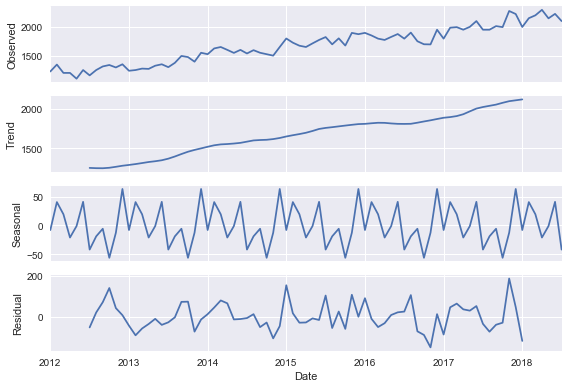

In [37]:
decomposed_df.plot()

- More complicated seasonality emerges here, showing a much lower dip in early fall/October area
- A lot of activity on the residual plot hints that randomness is prevalent

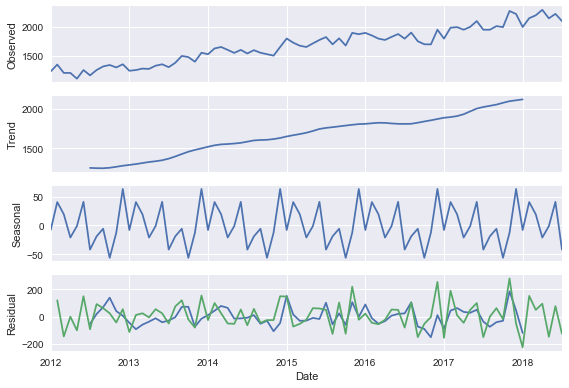

In [38]:
stationary_df = seasonal_df['RentalPrice_m']

#stationary_df = stationary_df.apply(np.log)
stationary_df = stationary_df - stationary_df.shift()
stationary_df.dropna(inplace=True)
stationary_df.plot()

plt.show()

## Testing Stationarity

In [40]:
dickey_df = test_stationarity(stationary_df,autolag='AIC')

Results of the Augmented Dickey-Fuller Test: 

                        Metric
Test Statistic      -4.702021
P-Value              0.000083
Lags Used            7.000000
Observations Taken  70.000000
1%                  -3.527426
5%                  -2.903811
10%                 -2.589320


### Fortunately, Differencing induced Stationarity

In [41]:
nonstationary_df = seasonal_df['RentalPrice_m']

In [42]:
dickey_df_2 = test_stationarity(nonstationary_df,autolag='AIC')

Results of the Augmented Dickey-Fuller Test: 

                        Metric
Test Statistic       0.125991
P-Value              0.967791
Lags Used            8.000000
Observations Taken  70.000000
1%                  -3.527426
5%                  -2.903811
10%                 -2.589320


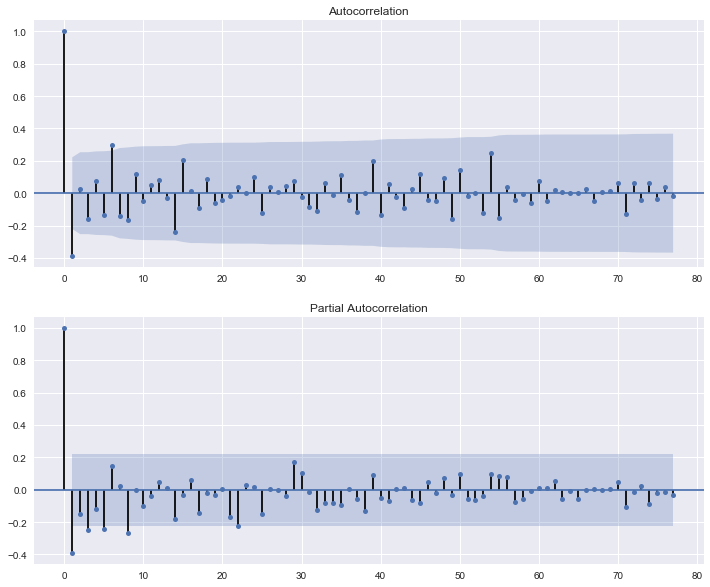

In [43]:
fig, axes = plt.subplots(2,1,figsize=(12,10))

tsaplots.plot_acf(stationary_df,ax=axes[0])
tsaplots.plot_pacf(stationary_df,ax=axes[1])

plt.show()

#### Looks like an AR(1) process at work ###

#### Time to check out the ARIMA model and see if the correlation (roughly -.4) can help us predict future values

In [44]:
new_df = np.cumsum(stationary_df) + seasonal_df.loc[seasonal_df.index.min(),'RentalPrice_m']

In [82]:
new_df.head()

Date
2012-02-01    1345.0
2012-03-01    1200.0
2012-04-01    1200.0
2012-05-01    1100.0
2012-06-01    1250.0
Name: RentalPrice_m, dtype: float64

In [45]:
df, corr = compute_correlation(stationary_df.values,stationary_df.shift(-3))

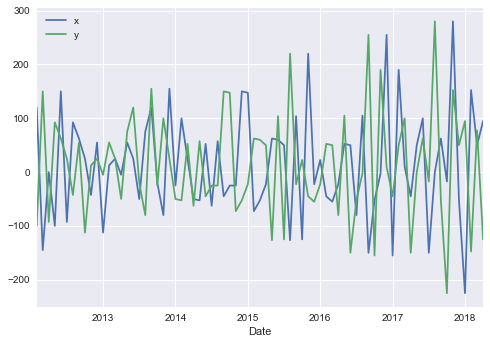

In [46]:
df.iloc[:,:2].plot()
plt.show()

In [47]:
stationary_df.values.reshape(-1).shape

(78,)

In [83]:
acf = acf_compute(stationary_df,stationary_df.shift(3))

78 75
75


In [50]:
acf

-0.16776278988542381

In [51]:
auto_corr = autocorrelate(stationary_df,lags=60)

In [52]:
conf_upper = [1.96 / np.sqrt(len(stationary_df)-i) for i in range(len(auto_corr))]
conf_lower = [-1.96 / np.sqrt(len(stationary_df)-i) for i in range(len(auto_corr))]

In [53]:
conf_upper[:5]

[0.22192629869234073,
 0.22336272986089037,
 0.2248274191931505,
 0.22632130552233326,
 0.22784537193788579]

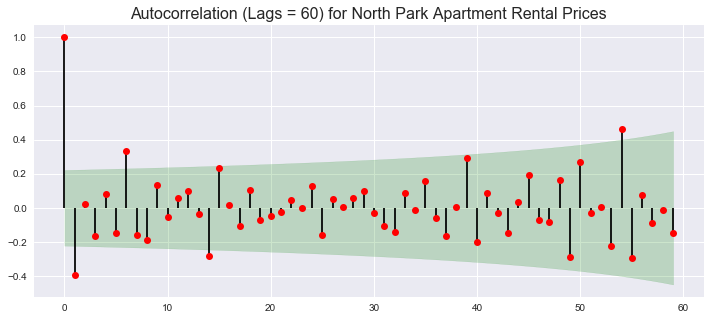

In [54]:
plt.figure(figsize=(12,5))

plt.plot(auto_corr,linestyle='none',marker='o',color='red')

for i, x in enumerate(auto_corr):
    plt.vlines(x=i,ymin=min(0,x),ymax=max(0,x))
    
plt.fill_between([i for i in range(len(auto_corr))],conf_lower,conf_upper,color='green',alpha=0.2)

plt.title('Autocorrelation (Lags = {}) for North Park Apartment Rental Prices'.format(len(auto_corr)),fontsize=16)

plt.show()

### Voila! A custom Autocorrelation function that resembles statsmodels acf function:

In [55]:
corr_5 = autocorrelate(stationary_df,lags=5)

In [56]:
corr_5

array([ 1.        , -0.3947204 ,  0.02431873, -0.16776279,  0.07822033])

In [57]:
from statsmodels.tsa.stattools import acf, acovf

In [58]:
acf(stationary_df)

array([ 1.        , -0.38882057,  0.02322911, -0.15959126,  0.07365837,
       -0.13575255,  0.29939948, -0.14356248, -0.16647718,  0.1208784 ,
       -0.04850038,  0.04826014,  0.08387316, -0.03035102, -0.24173771,
        0.20280736,  0.01502265, -0.08958804,  0.0901297 , -0.05982817,
       -0.0412924 , -0.01946223,  0.03763995, -0.0015102 ,  0.10242088,
       -0.12240747,  0.03946236,  0.00531071,  0.04417564,  0.07471014,
       -0.02262651, -0.08309102, -0.10748991,  0.06584696, -0.01123356,
        0.11518917, -0.04153492, -0.11621375,  0.00410955,  0.19908905,
       -0.13562694])

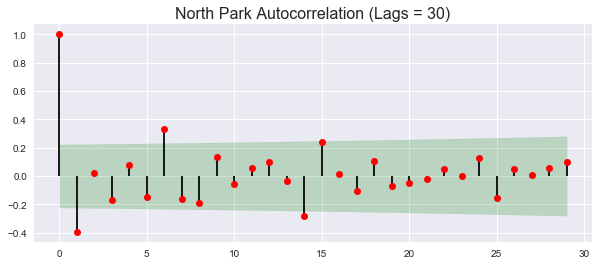

In [59]:
plt.figure(figsize=(10,4))

plot_auto_corr(stationary_df,title='North Park Autocorrelation',lags=30)

In [60]:
autocorrelate(stationary_df,conf_int=True,lags=30)

(array([ 1.        , -0.3947204 ,  0.02431873, -0.16776279,  0.07822033,
        -0.14897997,  0.33375708, -0.16170862, -0.18798691,  0.13652492,
        -0.05503625,  0.05489325,  0.09768805, -0.03574485, -0.28163665,
         0.2362218 ,  0.01740403, -0.10480322,  0.10628024, -0.07084963,
        -0.0499521 , -0.02353975,  0.04623006, -0.00179239,  0.12966147,
        -0.15689867,  0.05074256,  0.00680089,  0.05744169,  0.0975595 ]),
 array([ 0.2219263 ,  0.22336273,  0.22482742,  0.22632131,  0.22784537,
         0.22940065,  0.23098822,  0.23260921,  0.23426481,  0.23595627,
         0.23768491,  0.23945211,  0.24125932,  0.24310808,  0.245     ,
         0.24693679,  0.24892025,  0.25095228,  0.25303491,  0.25517027,
         0.25736061,  0.25960834,  0.26191602,  0.26428635,  0.26672222,
         0.26922671,  0.2718031 ,  0.2744549 ,  0.27718586,  0.28      ]),
 array([-0.2219263 , -0.22336273, -0.22482742, -0.22632131, -0.22784537,
        -0.22940065, -0.23098822, -0.23260921, 

### Now that we have figured out the ACF, Let's get to actual predictions

In [61]:
arima = ARIMA(stationary_df,order=(2,0,1))

In [62]:
fitted_arima = arima.fit()

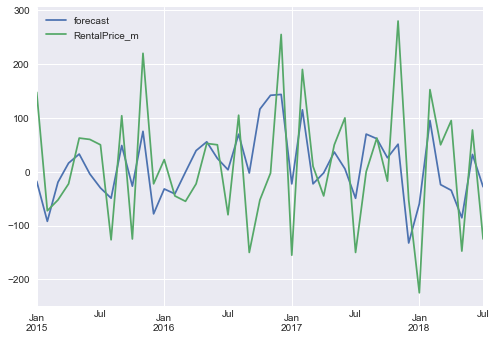

In [63]:
fitted_arima.plot_predict(start='2015-01-01',end='2018-07-01')

In [64]:
fitted_arima.forecast()

(array([ 73.28918814]),
 array([ 80.97755367]),
 array([[ -85.42390061,  232.00227689]]))

# Zooming out: Looking at the Bigger Picture #

* Build a tool that allows for time series analysis on different zip codes 
* Comparison between neighborhoods, do different AR-MA models explain different parts of the country?

In [65]:
list_of_geographies = ['State','Metro','County','City','Zip','Neighborhood']

In [66]:
zip_list = []

for g in list_of_geographies:
    zip_list.append(ZipFile(urlretrieve('http://files.zillowstatic.com/research/public/{}.zip'.format(g),'{}.zip'.format(g))[0],'r'))

In [67]:
csv_list_rental = []

for i in zip_list:
    x = i.namelist()
    csv_list_rental.append(sorted(list(chain.from_iterable([re.findall('.+MedianRentalPrice.+',z) for z in x]))))
    

In [68]:
csv_list_rental

[['State/State_MedianRentalPricePerSqft_1Bedroom.csv',
  'State/State_MedianRentalPricePerSqft_2Bedroom.csv',
  'State/State_MedianRentalPricePerSqft_3Bedroom.csv',
  'State/State_MedianRentalPricePerSqft_4Bedroom.csv',
  'State/State_MedianRentalPricePerSqft_5BedroomOrMore.csv',
  'State/State_MedianRentalPricePerSqft_AllHomes.csv',
  'State/State_MedianRentalPricePerSqft_CondoCoop.csv',
  'State/State_MedianRentalPricePerSqft_DuplexTriplex.csv',
  'State/State_MedianRentalPricePerSqft_Mfr5Plus.csv',
  'State/State_MedianRentalPricePerSqft_Sfr.csv',
  'State/State_MedianRentalPricePerSqft_Studio.csv',
  'State/State_MedianRentalPrice_1Bedroom.csv',
  'State/State_MedianRentalPrice_2Bedroom.csv',
  'State/State_MedianRentalPrice_3Bedroom.csv',
  'State/State_MedianRentalPrice_4Bedroom.csv',
  'State/State_MedianRentalPrice_5BedroomOrMore.csv',
  'State/State_MedianRentalPrice_AllHomes.csv',
  'State/State_MedianRentalPrice_CondoCoop.csv',
  'State/State_MedianRentalPrice_DuplexTriplex.

In [69]:
dict_list = []

for i in csv_list_rental:
    
    dict_index = i[0].split('/')[0]
    
    dict_list.append({dict_index: [x.split('/')[1] for x in i]})
        
    print(dict_index)

State
Metro
County
City
Zip
Neighborhood


In [70]:
dict_list

[{'State': ['State_MedianRentalPricePerSqft_1Bedroom.csv',
   'State_MedianRentalPricePerSqft_2Bedroom.csv',
   'State_MedianRentalPricePerSqft_3Bedroom.csv',
   'State_MedianRentalPricePerSqft_4Bedroom.csv',
   'State_MedianRentalPricePerSqft_5BedroomOrMore.csv',
   'State_MedianRentalPricePerSqft_AllHomes.csv',
   'State_MedianRentalPricePerSqft_CondoCoop.csv',
   'State_MedianRentalPricePerSqft_DuplexTriplex.csv',
   'State_MedianRentalPricePerSqft_Mfr5Plus.csv',
   'State_MedianRentalPricePerSqft_Sfr.csv',
   'State_MedianRentalPricePerSqft_Studio.csv',
   'State_MedianRentalPrice_1Bedroom.csv',
   'State_MedianRentalPrice_2Bedroom.csv',
   'State_MedianRentalPrice_3Bedroom.csv',
   'State_MedianRentalPrice_4Bedroom.csv',
   'State_MedianRentalPrice_5BedroomOrMore.csv',
   'State_MedianRentalPrice_AllHomes.csv',
   'State_MedianRentalPrice_CondoCoop.csv',
   'State_MedianRentalPrice_DuplexTriplex.csv',
   'State_MedianRentalPrice_Mfr5Plus.csv',
   'State_MedianRentalPrice_Sfr.csv',

- A list of Dicts to make it easier for combining and finding patterns across different geographic regions

In [71]:
list(chain.from_iterable(list(dict_list[-1].values())))[-1]

'Neighborhood_MedianRentalPrice_Studio.csv'

In [72]:
mrp_studio = pd.read_csv(os.getcwd()+'\\'+tuple(dict_list[-1].items())[0][0]+'\\'+list(chain.from_iterable(list(dict_list[-1].values())))[-1])

In [73]:
mrp_studio.head()

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
0,Maryvale,Phoenix,AZ,Phoenix,Maricopa,1,NaN,NaN,NaN,895.0,...,1095.0,1095.0,1027.5,1025.0,1050.0,1062.5,1095.0,1095.0,1133.0,1150.0
1,Upper West Side,New York,NY,New York,New York,2,NaN,NaN,NaN,NaN,...,2695.0,2695.0,2650.0,2675.0,2707.5,2700.0,2715.0,2715.0,2700.0,2745.0
2,Upper East Side,New York,NY,New York,New York,3,NaN,NaN,NaN,NaN,...,2190.0,2195.0,2150.0,2150.0,2150.0,2150.0,2175.0,2195.0,2195.0,2200.0
3,East New York,New York,NY,New York,Kings,4,NaN,NaN,NaN,NaN,...,1951.0,2000.0,1987.5,1963.5,2100.0,2100.0,2100.0,2100.0,2100.0,2100.0
4,Paradise Valley,Phoenix,AZ,Phoenix,Maricopa,5,1400.0,1400.0,1485.0,1485.0,...,1500.0,1500.0,1500.0,1500.0,1550.0,1585.0,1515.0,1550.0,1550.0,1550.0


In [74]:
zip_mrp_studio = pd.read_csv(os.getcwd()+'\\'+tuple(dict_list[-2].items())[0][0]+'\\'+list(chain.from_iterable(list(dict_list[-2].values())))[-2])

In [75]:
zip_mrp_studio

,RegionName,City,State,Metro,CountyName,SizeRank,2010-02,2010-03,2010-04,2010-05,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05
0,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,...,3400.0,3375.0,3350.0,3405.0,3500.0,3500.0,3500.0,3452.5,3500.0,3500.0
1,60657,Chicago,IL,Chicago,Cook,2,NaN,NaN,NaN,NaN,...,2197.0,1995.0,1833.0,1947.5,1900.0,1880.0,1695.0,1800.0,1750.0,1800.0
2,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,NaN,...,3150.0,3125.0,3046.5,3150.0,3217.0,3183.5,3256.0,3100.0,3100.0,2986.5
3,75070,McKinney,TX,Dallas-Fort Worth,Collin,4,NaN,NaN,NaN,NaN,...,1875.0,1890.0,1850.0,1850.0,1850.0,1850.0,1850.0,1872.5,1950.0,1895.0
4,77494,Katy,TX,Houston,Harris,5,NaN,NaN,NaN,NaN,...,2100.0,2200.0,2325.0,2250.0,2200.0,2150.0,2150.0,2100.0,2150.0,2150.0
5,60614,Chicago,IL,Chicago,Cook,6,NaN,NaN,NaN,NaN,...,2875.0,2900.0,2700.0,2700.0,2665.0,2600.0,2505.0,2600.0,2650.0,2800.0
6,79936,El Paso,TX,El Paso,El Paso,7,NaN,NaN,NaN,NaN,...,1050.0,1050.0,1050.0,1025.0,1000.0,1000.0,995.0,1050.0,1050.0,1075.0
7,77084,Houston,TX,Houston,Harris,8,NaN,NaN,NaN,NaN,...,1480.0,1495.0,1450.0,1450.0,1450.0,1450.0,1450.0,1450.0,1500.0,1500.0
8,60640,Chicago,IL,Chicago,Cook,9,NaN,NaN,NaN,NaN,...,1250.0,1250.0,1225.0,1200.0,1200.0,1200.0,1125.0,1165.0,1205.0,1272.5
9,77449,Katy,TX,Houston,Harris,10,NaN,NaN,NaN,NaN,...,1425.0,1450.0,1425.0,1450.0,1450.0,1475.0,1492.5,1475.0,1475.0,1500.0


In [76]:
with sqlite3.connect('zillow.db') as db:
    pass

In [77]:
db.cursor()

In [78]:
k, v = tuple(dict_list[0].items())[0]

In [79]:
col_ids = []

for i in v:
    
    col_id = re.search('_.+\.',i).group()[1:-1]
    
    col_ids.append(col_id)

In [80]:
col_ids

['MedianRentalPricePerSqft_1Bedroom',
 'MedianRentalPricePerSqft_2Bedroom',
 'MedianRentalPricePerSqft_3Bedroom',
 'MedianRentalPricePerSqft_4Bedroom',
 'MedianRentalPricePerSqft_5BedroomOrMore',
 'MedianRentalPricePerSqft_AllHomes',
 'MedianRentalPricePerSqft_CondoCoop',
 'MedianRentalPricePerSqft_DuplexTriplex',
 'MedianRentalPricePerSqft_Mfr5Plus',
 'MedianRentalPricePerSqft_Sfr',
 'MedianRentalPricePerSqft_Studio',
 'MedianRentalPrice_1Bedroom',
 'MedianRentalPrice_2Bedroom',
 'MedianRentalPrice_3Bedroom',
 'MedianRentalPrice_4Bedroom',
 'MedianRentalPrice_5BedroomOrMore',
 'MedianRentalPrice_AllHomes',
 'MedianRentalPrice_CondoCoop',
 'MedianRentalPrice_DuplexTriplex',
 'MedianRentalPrice_Mfr5Plus',
 'MedianRentalPrice_Sfr',
 'MedianRentalPrice_Studio']

In [90]:
list(chain.from_iterable(list(dict_list[1].values())))

['Metro_MedianRentalPricePerSqft_1Bedroom.csv',
 'Metro_MedianRentalPricePerSqft_2Bedroom.csv',
 'Metro_MedianRentalPricePerSqft_3Bedroom.csv',
 'Metro_MedianRentalPricePerSqft_4Bedroom.csv',
 'Metro_MedianRentalPricePerSqft_5BedroomOrMore.csv',
 'Metro_MedianRentalPricePerSqft_AllHomes.csv',
 'Metro_MedianRentalPricePerSqft_CondoCoop.csv',
 'Metro_MedianRentalPricePerSqft_DuplexTriplex.csv',
 'Metro_MedianRentalPricePerSqft_Mfr5Plus.csv',
 'Metro_MedianRentalPricePerSqft_Sfr.csv',
 'Metro_MedianRentalPricePerSqft_Studio.csv',
 'Metro_MedianRentalPrice_1Bedroom.csv',
 'Metro_MedianRentalPrice_2Bedroom.csv',
 'Metro_MedianRentalPrice_3Bedroom.csv',
 'Metro_MedianRentalPrice_4Bedroom.csv',
 'Metro_MedianRentalPrice_5BedroomOrMore.csv',
 'Metro_MedianRentalPrice_AllHomes.csv',
 'Metro_MedianRentalPrice_CondoCoop.csv',
 'Metro_MedianRentalPrice_DuplexTriplex.csv',
 'Metro_MedianRentalPrice_Mfr5Plus.csv',
 'Metro_MedianRentalPrice_Sfr.csv',
 'Metro_MedianRentalPrice_Studio.csv']

In [102]:
for i in list(chain.from_iterable(list(dict_list[1].values()))):
    b_type = (i.split('_')[2][:-4])
    g_type = (i.split('_')[0])
    r_type = (i.split('_')[1])
    
    df = pd.read_csv(i)

FileNotFoundError: File b'Metro_MedianRentalPricePerSqft_1Bedroom.csv' does not exist

In [103]:
os.getcwd()+'\\'+tuple(dict_list[-2].items())[0][0]+'\\'+list(chain.from_iterable(list(dict_list[-2].values())))[-2]

'C:\\Users\\mgavin\\Projects\\zillow_apts\\Zip\\Zip_MedianRentalPrice_Sfr.csv'